In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
import uuid
import torch

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Define System and Simulation Parameters
N = 64  # Number of BS antennas
K = 4   # Number of users
M = 4   # Number of RF chains
omega = 0.3  # Tradeoff weight

I_max = 120  # Maximum outer iterations
sigma_n2 = 1.0  # Noise variance
mu = 0.01  # Step size for analog precoder
lambda_ = 0.01  # Step size for digital precoder
L = 20  # Number of paths for channel

# Convert to tensors
omega_t = torch.tensor(omega, dtype=torch.float32, device=device)
sigma_n2_t = torch.tensor(sigma_n2, dtype=torch.float32, device=device)
mu_t = torch.tensor(mu, dtype=torch.float32, device=device)
lambda_t = torch.tensor(lambda_, dtype=torch.float32, device=device)

# Step 2: Define Sensing Parameters
P = 3  # Number of desired sensing angles
theta_d = np.array([-60, 0, 60]) * np.pi / 180  # Desired angles in radians
delta_theta = 5 * np.pi / 180  # Half beamwidth
theta_grid = np.linspace(-np.pi / 2, np.pi / 2, 181)  # Angular grid [-90, 90] degrees
B_d = np.zeros(len(theta_grid))  # Desired beampattern
for t, theta_t in enumerate(theta_grid):
    for theta_p in theta_d:
        if abs(theta_t - theta_p) <= delta_theta:
            B_d[t] = 1

# Convert to tensors
theta_d_t = torch.tensor(theta_d, dtype=torch.float32, device=device)
theta_grid_t = torch.tensor(theta_grid, dtype=torch.float32, device=device)
B_d_t = torch.tensor(B_d, dtype=torch.float32, device=device)

# Wavenumber and antenna spacing
lambda_wave = 1  # Wavelength (normalized)
k = 2 * np.pi / lambda_wave
d = lambda_wave / 2  # Antenna spacing

k_t = torch.tensor(k, dtype=torch.float32, device=device)
d_t = torch.tensor(d, dtype=torch.float32, device=device)

In [2]:
import h5py
SNR_dB_array = np.arange(0, 12.1, 0.1)
# Load Psi data (from MATLAB .mat file)
with h5py.File('Psi_all.mat', 'r') as f:
    Psi_h5 = f['Psi_all']

    # If stored as MATLAB complex structure (real/imag parts separate)
    if np.issubdtype(Psi_h5.dtype, np.void):
        real = Psi_h5['real'][()]
        imag = Psi_h5['imag'][()]
        Psi_all = real + 1j * imag
    else:
        Psi_all = np.array(Psi_h5)

# Ensure Psi_all has shape: (num_SNRs, M, N)
Psi_all = np.squeeze(Psi_all)  # remove singleton dimensions if any


def compute_psi(snr_db):
    """
    Selects the Psi matrix corresponding to the closest SNR value.
    """
    # Find index of closest SNR
    idx = np.argmin(np.abs(SNR_dB_array - snr_db))

    # Select corresponding Psi
    Psi = Psi_all[idx, :, :]

    return Psi

In [3]:
realizations = 100
R_ZF_list = []
R_PGA_list = []

from lib.support_functions_torch import generate_channel_torch, compute_R_ZF_torch, proposed_initialization_torch, run_pga_torch
fixed_results = {}
# Evaluate ZF baseline and PGA 
for snr_db in range(0, 13, 2):
    R_ZF_sum = 0.0
    R_PGA_sum = 0.0
    for realization in range(realizations):
        H = generate_channel_torch(N, M, L, device, k_t, d_t)  # N x K channel matrix
        P_BS = sigma_n2 * 10**(snr_db / 10)
        P_BS = torch.tensor(P_BS, dtype=torch.float32, device=device)
        Psi = compute_psi(snr_db)
        Psi = torch.tensor(Psi, dtype=torch.complex64, device=device)

        R_ZF = compute_R_ZF_torch(H, sigma_n2, P_BS)
        R_ZF_sum += R_ZF.cpu().item()  # Convert to Python float

        A0, D0 = proposed_initialization_torch(H, theta_d, N, M, K, P_BS, device)
        _ , R_PGA, A, D = run_pga_torch(H, A0, D0, J=1, I_max=I_max,
                                  mu=mu, lambda_=lambda_, omega=omega,
                                  sigma_n2=sigma_n2, Psi=Psi, P_BS=P_BS, device=device)
        
        R_PGA_sum += R_PGA.cpu().item()  # Convert to Python float
        
    R_ZF_avg = R_ZF_sum / realizations
    R_PGA_avg = R_PGA_sum / realizations
    R_ZF_list.append(R_ZF_avg)
    R_PGA_list.append(R_PGA_avg)
    print(f"SNR = {snr_db:2d} dB → ZF Avg R = {R_ZF_avg:.4f} bps/Hz | PGA Avg R = {R_PGA_avg:.4f} bps/Hz")

fixed_results["ZF_Baseline"] = R_ZF_list
fixed_results["PGA_J1_fixed"] = R_PGA_list
    



SNR =  0 dB → ZF Avg R = 12.3345 bps/Hz | PGA Avg R = 2.3803 bps/Hz
SNR =  2 dB → ZF Avg R = 14.9998 bps/Hz | PGA Avg R = 3.0175 bps/Hz
SNR =  2 dB → ZF Avg R = 14.9998 bps/Hz | PGA Avg R = 3.0175 bps/Hz
SNR =  4 dB → ZF Avg R = 17.2452 bps/Hz | PGA Avg R = 3.7241 bps/Hz
SNR =  4 dB → ZF Avg R = 17.2452 bps/Hz | PGA Avg R = 3.7241 bps/Hz
SNR =  6 dB → ZF Avg R = 19.6995 bps/Hz | PGA Avg R = 4.6443 bps/Hz
SNR =  6 dB → ZF Avg R = 19.6995 bps/Hz | PGA Avg R = 4.6443 bps/Hz
SNR =  8 dB → ZF Avg R = 22.4884 bps/Hz | PGA Avg R = 5.5322 bps/Hz
SNR =  8 dB → ZF Avg R = 22.4884 bps/Hz | PGA Avg R = 5.5322 bps/Hz
SNR = 10 dB → ZF Avg R = 25.3144 bps/Hz | PGA Avg R = 7.0889 bps/Hz
SNR = 10 dB → ZF Avg R = 25.3144 bps/Hz | PGA Avg R = 7.0889 bps/Hz
SNR = 12 dB → ZF Avg R = 27.5504 bps/Hz | PGA Avg R = 8.4237 bps/Hz
SNR = 12 dB → ZF Avg R = 27.5504 bps/Hz | PGA Avg R = 8.4237 bps/Hz


In [6]:
from lib.dnn import UPGANet
from lib.support_functions_torch import (compute_rate_torch, generate_channel_torch_batch)
def evaluate_trained_upganet(model_path, J, num_realizations=100, snr_range=range(0, 13 , 2)):
    """
    Evaluate a trained UPGANet model and compute the average achievable rate vs SNR.
    """
    print("="*70)
    print(f"EVALUATING TRAINED UPGANet (J={J})")
    print("="*70)
    print(f"Model path: {model_path}")
    print(f"Device: {device}")
    print()

    # Instantiate model with the same I_max as training
    trained_model = UPGANet(N, M, K, omega, I_max=I_max, J=J).to(device)
    state_dict = torch.load(model_path, map_location=device)
    trained_model.load_state_dict(state_dict, strict=False)
    trained_model.eval()

    R_upganet_list = []

    for snr_db in snr_range:
        R_sum = 0.0
        P_BS = sigma_n2 * 10**(snr_db / 10)
        P_BS_t = torch.tensor(P_BS, dtype=torch.float32, device=device)
        Psi_t = torch.tensor(compute_psi(snr_db), dtype=torch.cfloat, device=device)
        H_batch = generate_channel_torch_batch(N, M, L=20, batch_size=num_realizations, device=device)


        for realization in range(num_realizations):
            H_t = H_batch[realization]
            # Initialization (same as before)
            A0, D0 = proposed_initialization_torch(H_t, theta_d_t, N, M, K, P_BS_t, device=device)

            with torch.no_grad():
                A_final, D_final = trained_model(H_t, A0, D0, Psi_t, sigma_n2_t, P_BS_t)

            # Compute achievable rate
            R = compute_rate_torch(H_t, A_final, D_final, sigma_n2_t)
            R_sum += R.item()

        R_avg = R_sum / num_realizations
        R_upganet_list.append(R_avg)
        print(f"SNR = {snr_db:2d} dB → Avg R = {R_avg:.4f} bps/Hz")

    return R_upganet_list


In [ ]:
evaluate_trained_upganet(N, M, K,  model_path, theta_d_t, sigma_n2_t, omega, sigma_n2, Psi_t,  J, num_realizations=100, snr_range=range(0, 13 , 2)):

trained_results = evaluate_trained_upganet(
    N, M, K,
    model_path="checkpoints/upganet_J1_final.pth",
    theta_d_t=theta_d_t,
    sigma_n2_t=sigma_n2_t,
    omega=omega,
    sigma_n2=sigma_n2,
    J=1,
    num_realizations=100,
    snr_range=range(0, 13, 2)
)

fixed_results['UPGANet_J20_trained'] = trained_results

trained_results = evaluate_trained_upganet(
    N, M, K,
    model_path="checkpoints/upganet_J10_final.pth",
    theta_d_t=theta_d_t,
    sigma_n2_t=sigma_n2_t,
    omega=omega,
    sigma_n2=sigma_n2,
    Psi_t=Psi_t,
    J=10,
     num_realizations=100,
    snr_range=range(0, 13, 2)
)
fixed_results['UPGANet_J10_trained'] = trained_results

EVALUATING TRAINED UPGANet (J=1)
Model path: checkpoints/upganet_J1_final.pth
Device: cpu

SNR =  0 dB → Avg R = 4.3246 bps/Hz
SNR =  0 dB → Avg R = 4.3246 bps/Hz
SNR =  2 dB → Avg R = 5.0302 bps/Hz
SNR =  2 dB → Avg R = 5.0302 bps/Hz
SNR =  4 dB → Avg R = 5.5298 bps/Hz
SNR =  4 dB → Avg R = 5.5298 bps/Hz
SNR =  6 dB → Avg R = 6.2121 bps/Hz
SNR =  6 dB → Avg R = 6.2121 bps/Hz
SNR =  8 dB → Avg R = 6.5915 bps/Hz
SNR =  8 dB → Avg R = 6.5915 bps/Hz
SNR = 10 dB → Avg R = 7.4511 bps/Hz
SNR = 10 dB → Avg R = 7.4511 bps/Hz
SNR = 12 dB → Avg R = 5.0251 bps/Hz
EVALUATING TRAINED UPGANet (J=10)
Model path: checkpoints/upganet_J10_final.pth
Device: cpu

SNR = 12 dB → Avg R = 5.0251 bps/Hz
EVALUATING TRAINED UPGANet (J=10)
Model path: checkpoints/upganet_J10_final.pth
Device: cpu

SNR =  0 dB → Avg R = 2.2447 bps/Hz
SNR =  0 dB → Avg R = 2.2447 bps/Hz
SNR =  2 dB → Avg R = 2.9140 bps/Hz
SNR =  2 dB → Avg R = 2.9140 bps/Hz
SNR =  4 dB → Avg R = 4.4284 bps/Hz
SNR =  4 dB → Avg R = 4.4284 bps/Hz
SNR

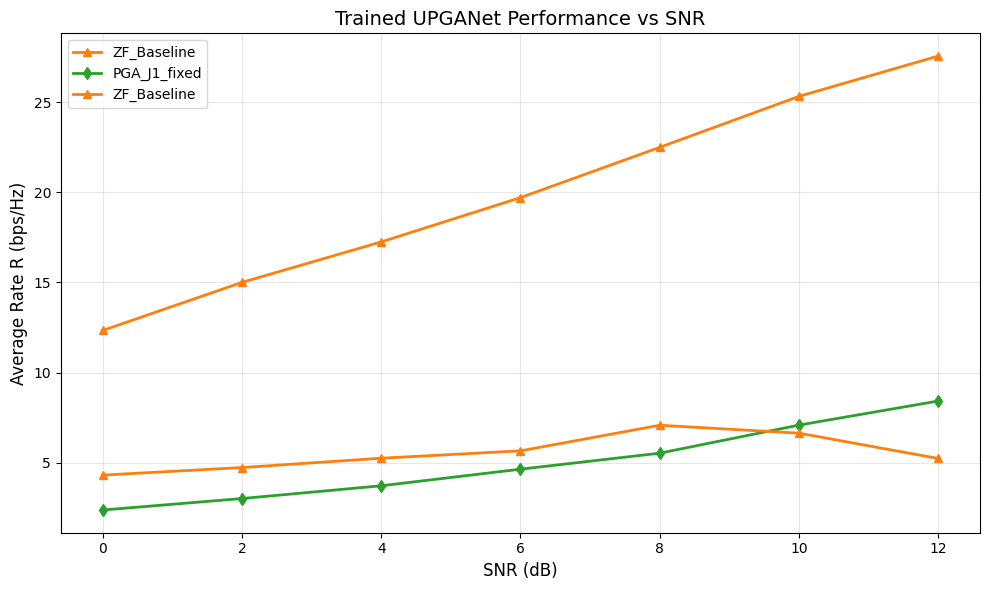

In [ ]:
# fixed_results['UPGANet_J20_trained'] = trained_results

# Re-plot including trained model
plt.figure(figsize=(10, 6))
snrs = list(range(0, 13, 2))

for label, rates in fixed_results.items():
    if 'UPGANet_J1_trained' in label:
        plt.plot(snrs, rates, marker='x', linewidth=2, color='black', linestyle='--', label='UPGANet_J1_trained')
    elif 'UPGANet_J10_trained' in label:
        plt.plot(snrs, rates, marker='o', linewidth=2, color='tab:blue', label='UPGANet_J10_trained')
    # # elif 'UPGANet_J20_trained' in label:
    # #     plt.plot(snrs, rates, marker='s', linewidth=2, color='tab:red', label='UPGANet_J20_trained')
    if 'PGA_J1_fixed' in label:
        plt.plot(snrs, rates, marker='d', linewidth=2, color='tab:green', label='PGA_J1_fixed')
    else:
        plt.plot(snrs, rates, marker='^', linewidth=2, color='tab:orange', label='ZF_Baseline')

plt.xlabel('SNR (dB)', fontsize=12)
plt.ylabel('Average Rate R (bps/Hz)', fontsize=12)
plt.title('Trained UPGANet Performance vs SNR', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()